# Parallelization for Microscopic Image Deconvolution

### Import related packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from time import time
from numba import cuda
from skimage import color
from scipy.signal import convolve

### Define Richardson-Lucy algorithm
Code largely borrowed from skimage.restorian package, not parallelized

In [2]:
def richardson_lucy(image, psf, num_iter=50):
   """Richardson-Lucy deconvolution without parallel computing

   Parameters
   ----------
   image : ndarray
      Input degraded image (can be N dimensional).
   psf : ndarray
      The point spread function.
   num_iter : int, optional
      Number of iterations. This parameter plays the role of
      regularisation.

   Returns
   -------
   im_deconv : ndarray
      The deconvolved image.

   References
   ----------
   [1] https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution
   [2] https://scikit-image.org/docs/stable/auto_examples/filters/plot_deconvolution.html
   """
   im_deconv = np.full(image.shape, 0.5, dtype=image.dtype)
   psf_mirror = np.flip(psf)

   # Small regularization parameter used to avoid 0 divisions
   eps = 1e-12
   accum = 0

   for _ in range(num_iter):
      start1 = time()
      conv = convolve(im_deconv, psf, mode='same', method='direct') + eps
      end1 = time()
      elapsed1 = end1 - start1
      relative_blur = image/conv
      start2 = time()
      im_deconv *= convolve(relative_blur, psf_mirror, mode='same', method='direct')
      end2 = time()
      elapsed2 = end2 - start2
      elapsed = (elapsed1 + elapsed2)/2
      accum += elapsed
   
   im_deconv[im_deconv > 1] = 1
   im_deconv[im_deconv < -1] = -1

   return accum/num_iter, im_deconv

### Results and time consumed for traditional R-L deconvolution algorithm

Richardson_Lucy execution time by CPU:  31.353063583374023 s
Average time for one convolution by CPU:  0.3126458525657654 s


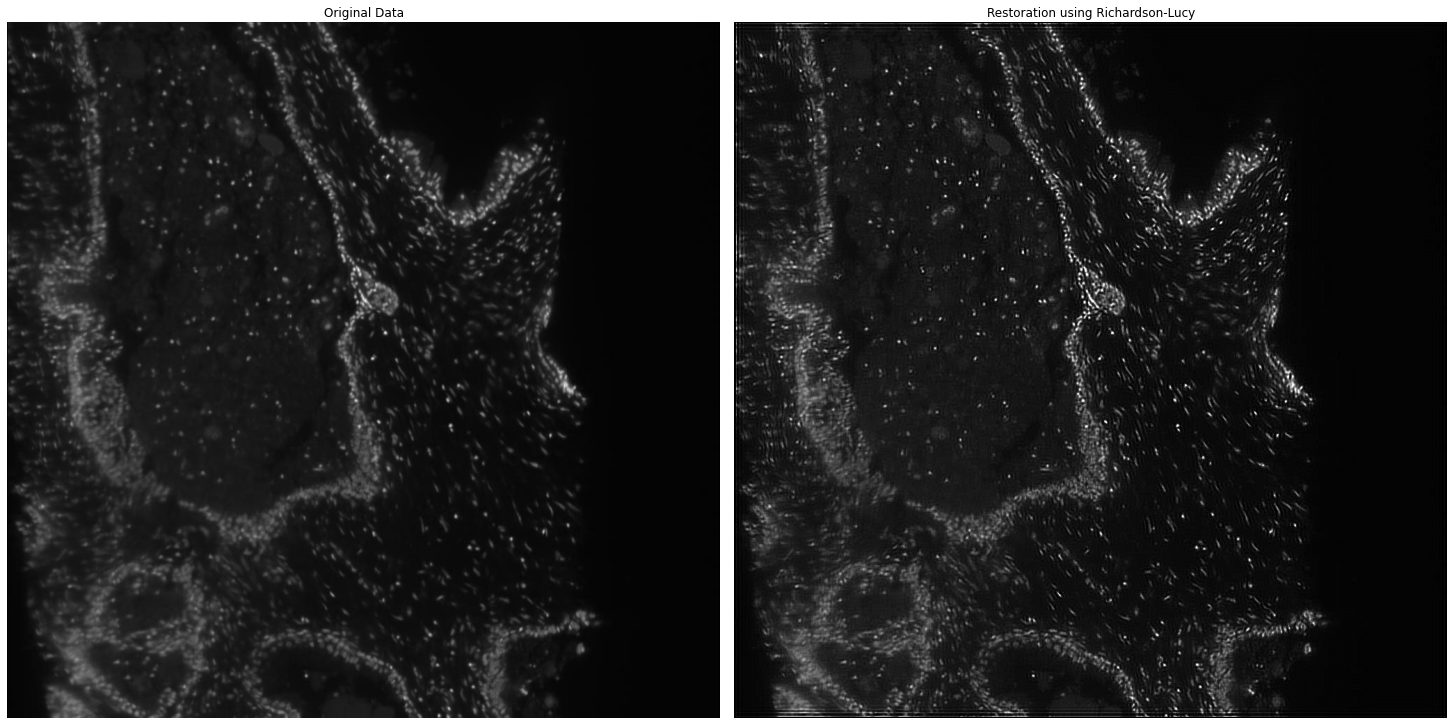

In [3]:
img = color.rgb2gray(cv2.imread('../data/test_nuclei_000004.jpg'))
psf = np.ones((5, 5))/25

# Restore Image using Richardson-Lucy algorithm
start = time()
conv_time, deconvolved_RL = richardson_lucy(img, psf)
end = time()
elapsed = end - start
print("Richardson_Lucy execution time by CPU: ", elapsed, "s")
print("Average time for one convolution by CPU: ", conv_time, "s")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
plt.gray()

for a in (ax[0], ax[1]):
       a.axis('off')

ax[0].imshow(img)
ax[0].set_title('Original Data')

ax[1].imshow(deconvolved_RL)
ax[1].set_title('Restoration using Richardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()

### Parallelize the convolution part of the R-L algorithm using stencil of any size

In [4]:
TPB = 16

@cuda.jit
def conv_kernel(d_v, d_u, d_PSF):
    """
    Compute the updated convolution array based on stencil and global memory arrays. \
    The size of the stencil is determined by the dimension of the PSF which is entered by the user. 
    
    Arguments:
        d_v: 2D float device array of updated values
        d_u: 2D float device array of current values
        d_PSF: array of PSF values 
    returns:
        None
    """
    i,j = cuda.grid(2)
    dims = d_u.shape
    s_i, s_j = cuda.grid(2)
    RAD = int(PSF.shape[0]//2) #finds the radius of the PSF function
    
    if RAD <= i <= dims[0] - RAD and RAD <= j <= dims[1] - RAD: #bounds check
        sum = 0
        for s_i in range(2*RAD +1): #the nested for loop computes the 25-point stencil for any PSF matrix
            for s_j in range(2*RAD +1):
                sum += d_PSF[s_i,s_j]*d_u[i-RAD+s_i,j-RAD+s_j]
                d_v[i,j] = sum

def conv(u, iter_count, PSF, memspec='global'):
    """
    Wrapper function for computing convolution using nD stencil and global memory. 
    
    Arguments:
        u: numpy float 2D array of current image
        iter_count: int number of update iterations
        PSF: array of PSF values 
        memspec: string; set memspec='shared' for updates based on shared memory kernel 
    Returns:
        convoluted 2D array of image
    """

    d_PSF = cuda.to_device(PSF)
    d_u = cuda.to_device(u)
    d_v = cuda.to_device(u)
    dims = u.shape
    gridDims = [(dims[0] + TPB - 1)//TPB, (dims[1] + TPB - 1)//TPB]
    blockDims = [TPB, TPB]

    event_start = cuda.event()
    event_end = cuda.event()
    event_start.record()
    for k in range(iter_count):
        conv_kernel[gridDims, blockDims](d_v, d_u, d_PSF)
        conv_kernel[gridDims, blockDims](d_u, d_v, d_PSF)
    event_end.record()
    event_end.synchronize()
    event_elapsed = cuda.event_elapsed_time(event_start, event_end)

    return event_elapsed, d_u.copy_to_host()


SH_N = 18
@cuda.jit
def shared_conv_kernel(d_v, d_u, d_PSF):
    """ 
    Compute the updated convolution array based on stencil and shared memory arrays. \
    The size of the stencil is determined by the dimension of the PSF which is entered by the user.   

    Arguments:
        d_v: 2D float device array of updated values
        d_u: 2D float device array of current values
        d_PSF: array of PSF values 
    returns:
        None
    """
    i,j = cuda.grid(2)
    dims = d_u.shape
    s_i, s_j = cuda.grid(2)
    RAD = int(PSF.shape[0]//2) #finds the radius of the PSF function
    
    if i >= dims[0] or j >= dims[1]:
        return

    NX, NY = cuda.blockDim.x, cuda.blockDim.y

    # define indices for threads and shared array
    t_i, t_j = cuda.threadIdx.x, cuda.threadIdx.y
    sh_i, sh_j = t_i + RAD, t_j + RAD

    #allocate memory for (and name) shared array
    sh_u = cuda.shared.array(shape = (SH_N,SH_N), dtype = np.float32)

    #Load regular values
    sh_u[sh_i, sh_j] = d_u[i, j]
    
    #tests for bounds checking before loads from global array
    left = i - RAD > 0
    right = i + NX < dims[0]
    up = j - RAD > 0
    down = j + NY < dims[1]
    
    #Halo edge values
    if t_i < RAD:
        if left:
            sh_u[sh_i - RAD, sh_j] = d_u[i - RAD, j]
        if right:
            sh_u[sh_i + NX , sh_j] = d_u[i + NX , j]

    if t_j < RAD:
        if up:
            sh_u[sh_i, sh_j - RAD] = d_u[i, j - RAD]
        if down:
            sh_u[sh_i, sh_j + NY ] = d_u[i, j + NY ]

    #Halo corner values
    if t_i < RAD and t_j < RAD:
        #upper left
        if left and up:
            sh_u[sh_i - RAD, sh_j - RAD] = d_u[i - RAD, j - RAD]
        #upper right
        if right and up:
            sh_u[sh_i + NX, sh_j - RAD] = d_u[i + NX, j - RAD]
        #lower left
        if left and down:
            sh_u[sh_i - RAD, sh_j + NY] = d_u[i - RAD, j + NY]
        #lower right
        if right and down:
            sh_u[sh_i + NX, sh_j + NX] = d_u[i + NX, j + NY]

    #make sure shared array is fully loaded before read
    cuda.syncthreads()

    #Proceed with the desired computation
    if RAD <= i <= dims[0] - RAD and RAD <= j <= dims[1] - RAD: #bounds check
        sum = 0
        for s_i in range(2*RAD +1): #the nested for loop computes the 25-point stencil for any PSF matrix
            for s_j in range(2*RAD +1):
                sum += d_PSF[s_i,s_j]*d_u[i-RAD+s_i,j-RAD+s_j]
                d_v[i,j] = sum

def shared_conv(u, iter_count, PSF, memspec='global'):
    """
    Wrapper function for computing convolution using nD stencil and shared memory. 
    
    Arguments:
        u: numpy float 2D array of current image
        iter_count: int number of update iterations
        PSF: array of PSF values 
        memspec: string; set memspec='shared' for updates based on shared memory kernel 
    Returns:
        convoluted 2D array of image
    """

    d_PSF = cuda.to_device(PSF)
    d_u = cuda.to_device(u)
    d_v = cuda.to_device(u)
    dims = u.shape
    gridDims = [(dims[0] + TPB - 1)//TPB, (dims[1] + TPB - 1)//TPB]
    blockDims = [TPB, TPB]

    event_start = cuda.event()
    event_end = cuda.event()
    event_start.record()
    for k in range(iter_count):
        shared_conv_kernel[gridDims, blockDims](d_v, d_u, d_PSF)
        shared_conv_kernel[gridDims, blockDims](d_u, d_v, d_PSF)
    event_end.record()
    event_end.synchronize()
    event_elapsed = cuda.event_elapsed_time(event_start, event_end)

    return event_elapsed, d_u.copy_to_host()


### Plot the image before and after the convolution

Average time for one convolution by GPU:  0.004753344058990479 s
Speedup factor for one convolution:  65.77387386348076


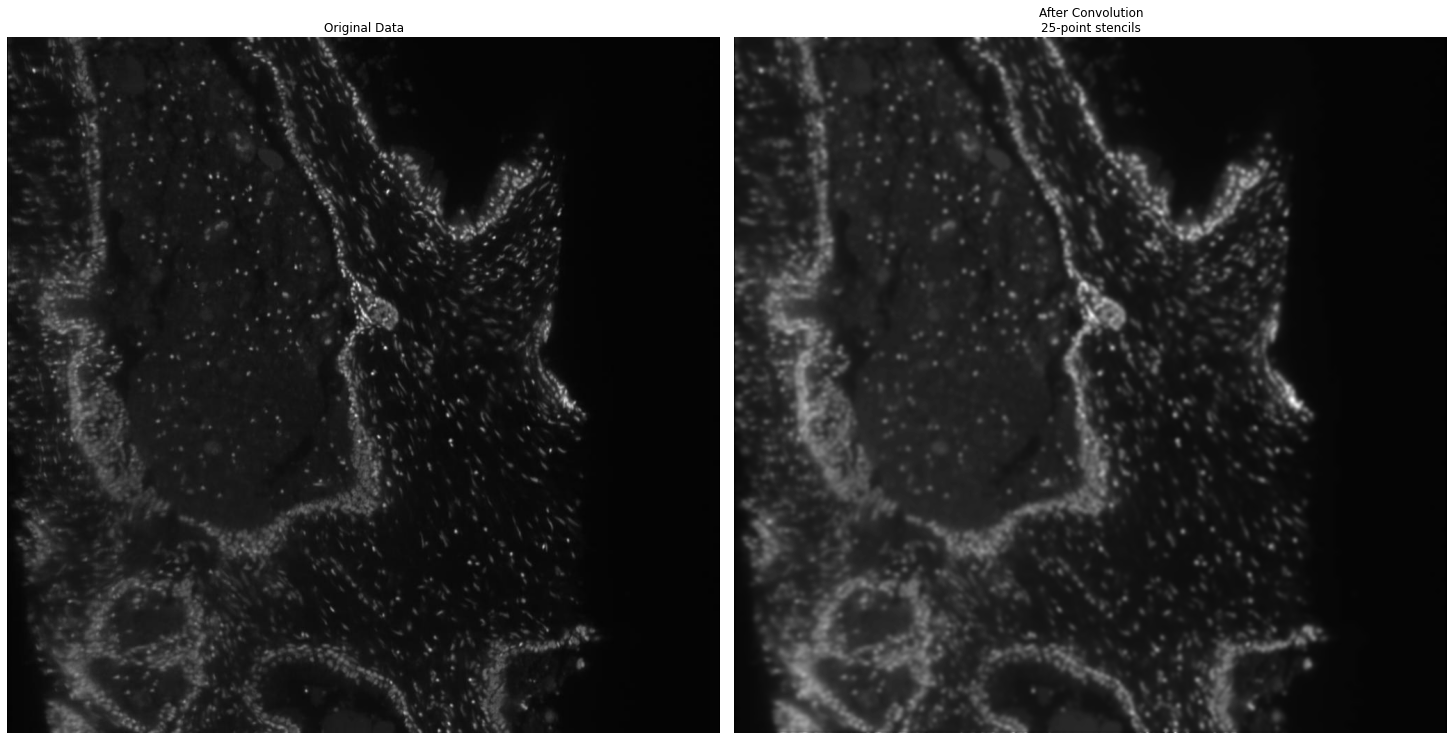

In [11]:
PSF = np.ones((5, 5))/25
event_time, convolved = conv(img, 1, psf)
event_time /= 1000
print("Average time for one convolution by GPU: ", event_time, "s")
print("Speedup factor for one convolution: ", conv_time/event_time)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
plt.gray()
for a in (ax[0], ax[1]):
       a.axis('off')
ax[0].imshow(img)
ax[0].set_title('Original Data')
ax[1].imshow(convolved)
ax[1].set_title('After Convolution\n25-point stencils')

fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()


### Implement the parallelized version of R-L algorithm

In [6]:
def rl_par(image, psf, num_iter=50):
   """Richardson-Lucy deconvolution.

   Arguments:
        image : ndarray
            Input degraded image (can be N dimensional).
        psf : ndarray
            The point spread function.
        num_iter : int, optional
            Number of iterations. This parameter plays the role of
            regularisation.

   Returns:
        im_deconv : ndarray
        The deconvolved image.

   References:
   [1] https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution
   [2] https://scikit-image.org/docs/stable/auto_examples/filters/plot_deconvolution.html
   """

   im_deconv = np.full(image.shape, 0.5, dtype=image.dtype)
#    psf_mirror = np.flip(psf)

   # Small regularization parameter used to avoid 0 divisions
   eps = 1e-12
   elapsed = 0
   cputime = 0
   for _ in range(num_iter):
      start1 = time()
      elapsed1, con = conv(im_deconv, 1, psf)
      end1 = time()
      cputime1 = end1 - start1
      con += eps
      relative_blur = image/con
      start2 = time()
      elapsed2, con = conv(relative_blur, 1, psf) #
      end2 = time()
      cputime2 = end2 - start2
      im_deconv *= con
      elapsed = elapsed + elapsed1 + elapsed2
      cputime = cputime + cputime1 + cputime2

      
   im_deconv[im_deconv > 1] = 1
   im_deconv[im_deconv < -1] = -1

   return cputime, elapsed/1000, im_deconv


def shared_rl_par(image, psf, num_iter=50):
   """Richardson-Lucy deconvolution based on shared memory

   Arguments:
        image : ndarray
            Input degraded image (can be N dimensional).
        psf : ndarray
            The point spread function.
        num_iter : int, optional
            Number of iterations. This parameter plays the role of
            regularisation.

   Returns:
        im_deconv : ndarray
        The deconvolved image.

   References:
   [1] https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution
   [2] https://scikit-image.org/docs/stable/auto_examples/filters/plot_deconvolution.html
   """

   im_deconv = np.full(image.shape, 0.5, dtype=image.dtype)

   # Small regularization parameter used to avoid 0 divisions
   eps = 1e-12
   elapsed = 0
   cputime = 0
   for _ in range(num_iter):
      start1 = time()
      elapsed1, con = shared_conv(im_deconv, 1, psf)
      end1 = time()
      cputime1 = end1 - start1
      con += eps
      relative_blur = image/con
      start2 = time()
      elapsed2, con = shared_conv(relative_blur, 1, psf) #
      end2 = time()
      cputime2 = end2 - start2
      im_deconv *= con
      elapsed = elapsed + elapsed1 + elapsed2
      cputime = cputime + cputime1 + cputime2

      
   im_deconv[im_deconv > 1] = 1
   im_deconv[im_deconv < -1] = -1

   return cputime, elapsed/1000, im_deconv

### Experiment of the parallelized deconvolution algorithm and time consumed

In [32]:
psf = np.ones((5, 5))/25
start = time()
cputime_gl, elapsed_par1, deconvolved_RL_global = rl_par(img, psf)
deconvolved_RL_global
end = time()
elapsed_par_gl = end - start - cputime_gl + elapsed_par1
print("Global memory: execution time: ", elapsed_par_gl, "s")
print("Speedup factor: ", elapsed/elapsed_par_gl)
print()

psf = np.ones((5, 5))/25
start = time()
cputime_sh, elapsed_par2, deconvolved_RL_shared = shared_rl_par(img, psf)
deconvolved_RL_shared
end = time()
elapsed_par_sh = end - start - cputime_sh + elapsed_par2
print("Shared memory: execution time: ", elapsed_par_sh, "s")
print("Speedup factor: ", elapsed/elapsed_par_sh)

device = cuda.get_current_device()
print(device)


Global memory: execution time:  0.6121872081756592 s
Speedup factor:  51.21482965448972

Shared memory: execution time:  0.6101815595626832 s
Speedup factor:  51.38317127421017
<CUDA device 0 'b'Quadro P6000''>


### Plot the processed images

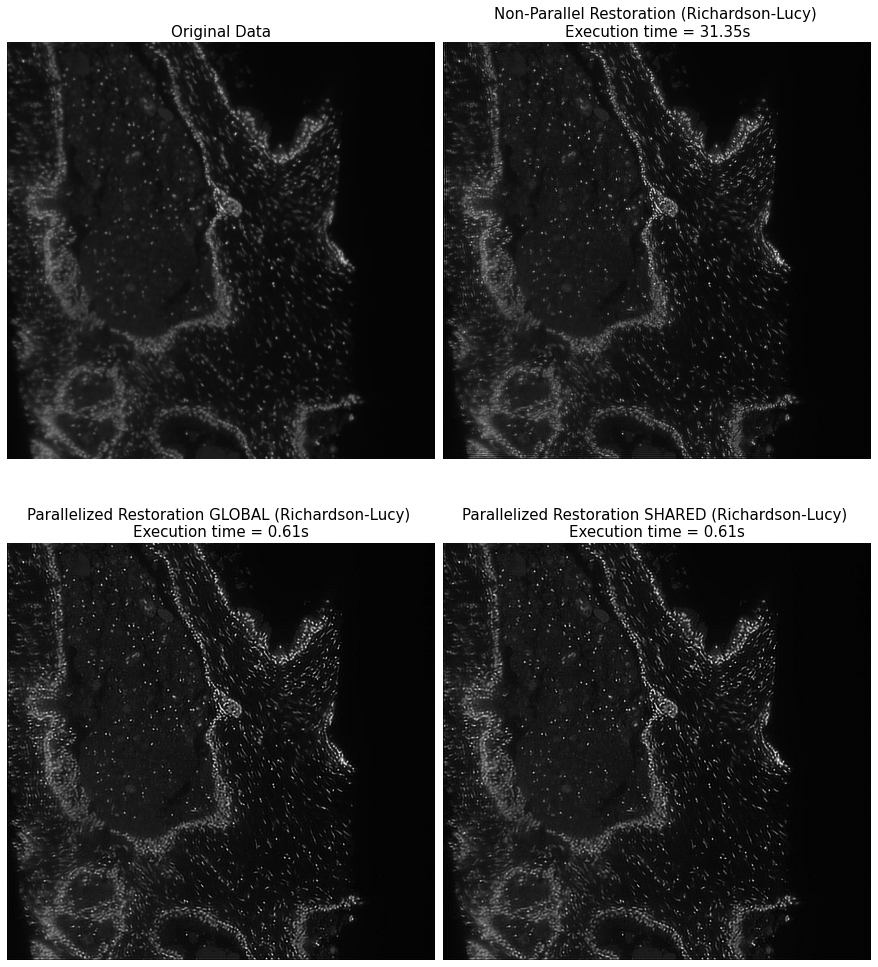

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
plt.gray()

for a in (ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]):
       a.axis('off')

ax[0,0].imshow(img)
ax[0,0].set_title('Original Data',fontsize=15)

ax[0,1].imshow(deconvolved_RL)
ax[0,1].set_title('Non-Parallel Restoration (Richardson-Lucy) \n'+ "Execution time = " + str('%.2f' % elapsed) + 's', fontsize=15)

ax[1,0].imshow(deconvolved_RL_global)
ax[1,0].set_title('Parallelized Restoration GLOBAL (Richardson-Lucy) \n'+ "Execution time = " + str('%.2f' % elapsed_par_gl) + 's',fontsize=15)

ax[1,1].imshow(deconvolved_RL_shared)
ax[1,1].set_title('Parallelized Restoration SHARED (Richardson-Lucy) \n'+ "Execution time = " + str('%.2f' % elapsed_par_sh) + 's',fontsize=15)



fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0.1, right=0.9)


plt.show()
fig.savefig('../img/Comp.jpg')


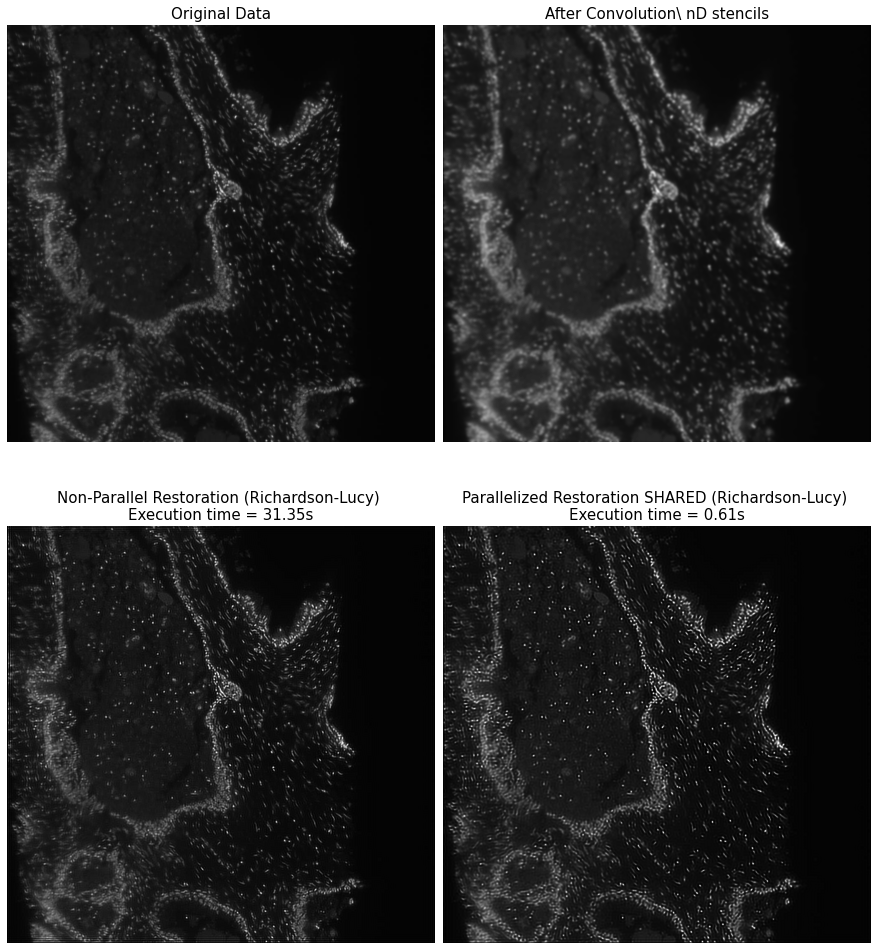

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
plt.gray()

for a in (ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]):
       a.axis('off')

ax[0, 0].imshow(img)
ax[0, 0].set_title('Original Data',fontsize=15)

ax[0, 1].imshow(convolved)
ax[0, 1].set_title('After Convolution\ nD stencils',fontsize=15)

ax[1, 0].imshow(deconvolved_RL)
ax[1, 0].set_title('Non-Parallel Restoration (Richardson-Lucy) \n'+ "Execution time = " + str('%.2f' % elapsed) + 's', fontsize=15)

ax[1, 1].imshow(deconvolved_RL_global)
ax[1, 1].set_title('Parallelized Restoration SHARED (Richardson-Lucy) \n'+ "Execution time = " + str('%.2f' % elapsed_par_sh) + 's',fontsize=15)


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0.2, right=1)
plt.show()


### Comparison for batch processing

In [10]:
import os
filelist = os.listdir("../data/")

start = time()
for i in filelist:
    img = color.rgb2gray(cv2.imread('../data/' + i))
    _, deconvolved_RL = richardson_lucy(img, psf)
end = time()
elapsed_cpu = end - start
print("CPU: Richardson_lucy execution time for batch images: ", elapsed_cpu, "s")

start = time()
for i in filelist:
    print('Processing', i)
    img = color.rgb2gray(cv2.imread('../data/' + i))
    _, foo, deconvolved_RL_par = rl_par(img, psf)
end = time()
elapsed_gpu = end - start
print("Global GPU: Richardson_lucy execution time for batch images: ", elapsed_gpu, "s")
print("Speedup factor: ", elapsed_cpu/elapsed_gpu)
